Medium post: https://medium.com/@gabogarza/exoplanet-hunting-with-machine-learning-and-kepler-data-recall-100-155e1ddeaa95

Github repo: https://github.com/gabrielgarza/exoplanet-deep-learning

### Import libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC, LinearSVC, NuSVC
from scipy import ndimage, fft
from sklearn.preprocessing import normalize
import os
root_dir = "./Data/kepler/data_no_injection"
print(os.listdir(root_dir))
import seaborn as sns

['exoTest.csv', 'exoTrain.csv']


## Data Preprocessor

In [26]:
import pandas as pd
import numpy as np
from scipy import ndimage, fft
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

class LightFluxProcessor:

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    def fourier_transform(self, X):
        return np.abs(fft.fft(X, n=X.size))

    def process(self, df_train_x, df_dev_x):
        # Apply fourier transform
        if self.fourier:
            print("Applying Fourier...")
            shape_train = df_train_x.shape
            shape_dev = df_dev_x.shape
            df_train_x = df_train_x.apply(self.fourier_transform,axis=1)
            df_dev_x = df_dev_x.apply(self.fourier_transform,axis=1)

            df_train_x_build = np.zeros(shape_train)
            df_dev_x_build = np.zeros(shape_dev)

            for ii, x in enumerate(df_train_x):
                df_train_x_build[ii] = x

            for ii, x in enumerate(df_dev_x):
                df_dev_x_build[ii] = x
            
            df_train_x = pd.DataFrame(df_train_x_build)
            df_dev_x = pd.DataFrame(df_dev_x_build)


            # Keep first half of data as it is symmetrical after previous steps
            df_train_x = df_train_x.iloc[:,:(df_train_x.shape[1]//2)].values
            df_dev_x = df_dev_x.iloc[:,:(df_dev_x.shape[1]//2)].values

        # Normalize
        if self.normalize:
            print("Normalizing...")
            df_train_x = pd.DataFrame(normalize(df_train_x))
            df_dev_x = pd.DataFrame(normalize(df_dev_x))

            # df_train_x = df_train_x.div(df_train_x.sum(axis=1), axis=0)
            # df_dev_x = df_dev_x.div(df_dev_x.sum(axis=1), axis=0)


        # Gaussian filter to smooth out data
        if self.gaussian:
            print("Applying Gaussian Filter...")
            df_train_x = ndimage.gaussian_filter(df_train_x, sigma=10)
            df_dev_x = ndimage.gaussian_filter(df_dev_x, sigma=10)

        if self.standardize:
            # Standardize X data
            print("Standardizing...")
            std_scaler = StandardScaler()
            df_train_x = std_scaler.fit_transform(df_train_x)
            df_dev_x = std_scaler.transform(df_dev_x)

        print("Finished Processing!")
        return df_train_x, df_dev_x


### Load datasets

In [27]:
train_dataset_path = os.path.join(root_dir, "./exoTrain.csv")
dev_dataset_path = os.path.join(root_dir, "./exoTest.csv")

print("Loading datasets...")
df_train = pd.read_csv(train_dataset_path, encoding = "ISO-8859-1")
df_dev = pd.read_csv(dev_dataset_path, encoding = "ISO-8859-1")
print("Loaded datasets!")

# Generate X and Y dataframe sets
df_train_x = df_train.drop('LABEL', axis=1)
df_dev_x = df_dev.drop('LABEL', axis=1)
df_train_y = df_train.LABEL
df_dev_y = df_dev.LABEL
df_train

Loading datasets...
Loaded datasets!


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


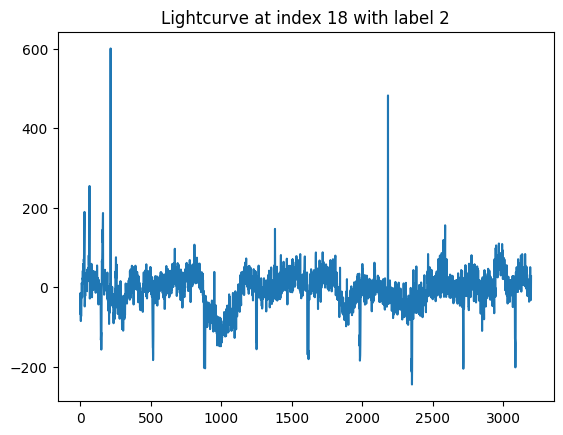

In [28]:

data = df_train_x.to_numpy()
ii = 0
while ii < len(data):
    index = np.random.randint(0, len(data))
    label = df_train_y[index]
    if label == 2.0:
        plt.figure()
        plt.plot(range(len(data[index, :])), data[index, :])
        plt.title(f"Lightcurve at index {index} with label {label}")
        break
    ii += 1

### Process data and create numpy matrices

In [29]:
def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(['LABEL'], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df['LABEL']).reshape((len(df['LABEL']),1))
    Y = Y_raw == 2
    return X, Y

In [30]:
# Process dataset
LFP = LightFluxProcessor(
    fourier=True,
    normalize=True,
    gaussian=True,
    standardize=True)
df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

# display(df_train_x)


# Rejoin X and Y
df_train_processed = pd.DataFrame(df_train_x).join(pd.DataFrame(df_train_y))
df_dev_processed = pd.DataFrame(df_dev_x).join(pd.DataFrame(df_dev_y))

# Load X and Y numpy arrays
X_train, Y_train = np_X_Y_from_df(df_train_processed)
Y_train = Y_train.ravel()
X_dev, Y_dev = np_X_Y_from_df(df_dev_processed)
Y_dev = Y_dev.ravel()

Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!


### Describe datasets

In [31]:
(num_examples, n_x) = X_train.shape # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[0] # n_y : output size
print("X_train.shape: ", X_train.shape)
print("Y_train.shape: ", Y_train.shape)
print("X_dev.shape: ", X_dev.shape)
print("Y_dev.shape: ", Y_dev.shape)
print("n_x: ", n_x)
print("num_examples: ", num_examples)
print("n_y: ", n_y)

X_train.shape:  (5087, 1598)
Y_train.shape:  (5087,)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570,)
n_x:  1598
num_examples:  5087
n_y:  5087


## Build Model, Train, and Predict

In [32]:
LinearModel = LinearSVC()
PolyModel = SVC(kernel="poly", degree=3)
GaussianModel = SVC(kernel="rbf")

full_start = time.time()
# Fit Linear Model
print("Fitting Linear Model                                        ", end="")
start = time.time()
LinearModel.fit(X_train,Y_train)
finish = time.time()
print(f"\rLinear Model Training Time: {finish- start:.2f}s")

# Fit Gaussian Model
print("Fitting Gaussian Model                                        ", end="")
start = time.time()
GaussianModel.fit(X_train,Y_train)
finish = time.time()
print(f"\rGaussian Model Training Time: {finish- start:.2f}s")

# Fit Poly Model
print("Fitting Poly Model                                        ", end="")
start = time.time()
PolyModel.fit(X_train,Y_train)
finish = time.time()
print(f"\rPoly Model Training Time: {finish- start:.2f}s")

full_finish = time.time()

print(f"\nFinished Training in {full_finish - full_start:.2f}!")

Linear Model Training Time: 2.98s                           
Gaussian Model Training Time: 0.24s                           
Poly Model Training Time: 0.08s                           

Finished Training in 3.30!


## Calculate and Display Metrics

In [33]:
# Metrics
## Model Outputs
linear_train_outputs = LinearModel.predict(X_train)
poly_train_outputs = PolyModel.predict(X_train)
gaussian_train_outputs = GaussianModel.predict(X_train)

linear_test_outputs = LinearModel.predict(X_dev)
poly_test_outputs = PolyModel.predict(X_dev)
gaussian_test_outputs = GaussianModel.predict(X_dev)


## Accuracy
### Train Accuracy
linear_train_accuracy = accuracy_score(Y_train, linear_train_outputs)
gaussian_train_accuracy = accuracy_score(Y_train, gaussian_train_outputs)
poly_train_accuracy = accuracy_score(Y_train, poly_train_outputs)
### Test Accuracy
linear_test_accuracy = accuracy_score(Y_dev, linear_test_outputs)
gaussian_test_accuracy = accuracy_score(Y_dev, gaussian_test_outputs)
poly_test_accuracy = accuracy_score(Y_dev, poly_test_outputs)

## Precision
### Train Precision
linear_train_precision = precision_score(Y_train, linear_train_outputs)
gaussian_train_precision = precision_score(Y_train, gaussian_train_outputs)
poly_train_precision = precision_score(Y_train, poly_train_outputs)
### Test Precision
linear_test_precision = precision_score(Y_dev, linear_test_outputs)
gaussian_test_precision = precision_score(Y_dev, gaussian_test_outputs)
poly_test_precision = precision_score(Y_dev, poly_test_outputs)

## Confusion Matrix
## Test Confusion matrix
linear_test_confmat = confusion_matrix(Y_dev, linear_test_outputs)
poly_test_confmat = confusion_matrix(Y_dev, poly_test_outputs)
gaussian_test_confmat = confusion_matrix(Y_dev, gaussian_test_outputs)


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Accuracy ###
## Training ##
Linear: 1.00
Polynomial: 1.00
Gaussian: 1.00
## Test ##
Linear: 0.99
Polynomial: 0.99
Gaussian: 0.99
### Precision ###
## Training ##
Linear: 1.00
Polynomial: 1.00
Gaussian: 1.00
## Test ##
Linear: 0.42
Polynomial: 0.00
Gaussian: 0.00


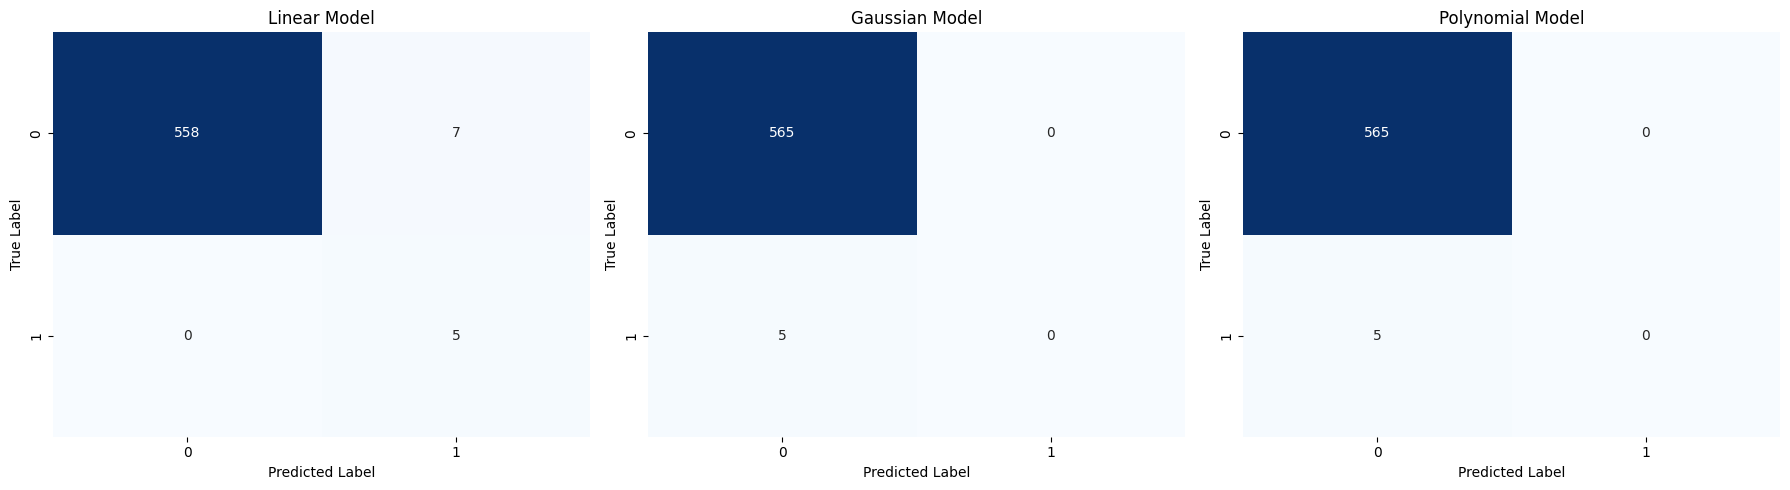

In [34]:
# Metrics Printing
print("### Accuracy ###")
print("## Training ##")
print(f"Linear: {linear_train_accuracy:.2f}\nPolynomial: {poly_train_accuracy:.2f}\nGaussian: {gaussian_train_accuracy:.2f}")
print("## Test ##")
print(f"Linear: {linear_test_accuracy:.2f}\nPolynomial: {poly_test_accuracy:.2f}\nGaussian: {gaussian_test_accuracy:.2f}")

print("### Precision ###")
print("## Training ##")
print(f"Linear: {linear_train_precision:.2f}\nPolynomial: {poly_train_precision:.2f}\nGaussian: {gaussian_train_precision:.2f}")
print("## Test ##")
print(f"Linear: {linear_test_precision:.2f}\nPolynomial: {poly_test_precision:.2f}\nGaussian: {gaussian_test_precision:.2f}")

disp_linear = ConfusionMatrixDisplay(linear_test_confmat)
disp_gaussian = ConfusionMatrixDisplay(gaussian_test_confmat)
disp_poly = ConfusionMatrixDisplay(poly_test_confmat)

conf_matrices = {
    "Linear": linear_test_confmat,
    "Gaussian": gaussian_test_confmat,
    "Polynomial": poly_test_confmat
}

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot each confusion matrix
for ax, (name, matrix) in zip(axes, conf_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"{name} Model")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [35]:
# Define the precision scores and confusion matrices
precisions = {
    "Linear Train Precision": linear_train_precision,
    "Gaussian Train Precision": gaussian_train_precision,
    "Polynomial Train Precision": poly_train_precision,
    "Linear Test Precision": linear_test_precision,
    "Gaussian Test Precision": gaussian_test_precision,
    "Polynomial Test Precision": poly_test_precision
}

conf_matrices = {
    "Linear Test Confusion Matrix": linear_test_confmat,
    "Gaussian Test Confusion Matrix": gaussian_test_confmat,
    "Polynomial Test Confusion Matrix": poly_test_confmat
}

# Write the results to a text file
with open("report_no_injection_assignment2_taskD.txt", "w") as file:
    # Write precision scores
    file.write("Precision Scores:\n")
    for key, value in precisions.items():
        file.write(f"{key}: {value:.3f}\n")
    
    file.write("\nConfusion Matrices:\n")
    # Write confusion matrices
    for key, matrix in conf_matrices.items():
        file.write(f"{key}:\n")
        np.savetxt(file, matrix, fmt="%d")
        file.write("\n")